In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect


In [2]:
#import
station_location = pd.read_csv('../Data/Nice_Ride_2017_Station_Locations.csv', low_memory=False)
trip_history = pd.read_csv('../Data/Nice_ride_trip_history_2017_season.csv', low_memory=False)

#test
station_location.sample(n=5)
trip_history.sample(n=5)

,ID,Start Date,Start Time,Start station,Start station number,End Date,End Time,End station,End station number,Account type,Total duration (Seconds),Duration (Min)
281529,281530,7/1/2017,6:45,West 15th Street & Willow,30093,7/1/2017,13:24,10th Street & Nicollet Mall,30039,Member,503,8.383333
373347,373348,5/26/2017,0:45,Lake Calhoun Center,30089,5/26/2017,15:50,Lake Calhoun Center,30089,Member,1257,20.950000
323042,323043,6/16/2017,23:45,Sanford Hall,30182,6/16/2017,8:48,Elliot Hall,30058,Member,234,3.900000
302950,302951,6/23/2017,19:45,Chicago Ave & S Washington Ave,30143,6/23/2017,23:09,Nicollet & Franklin,30060,Member,1888,31.466667
177529,177530,8/4/2017,22:45,15th Ave SE & 4th Street SE,30197,8/4/2017,23:13,15th Ave SE & Como Ave SE,30110,Member,274,4.566667


In [8]:
#test
station_location = pd.DataFrame(station_location)
trip_history = pd.DataFrame(trip_history)

station_location

,ID,Number,Name,Latitude,Longitude,Total docks
0,1,30000,100 Main Street SE,44.984892,-93.256551,27
1,2,30001,25th Street & 33rd Ave S,44.957341,-93.223374,15
2,3,30002,Riverside Ave & 23rd Ave S,44.967115,-93.240149,15
3,4,30003,Plymouth Ave N & N Oliver Ave,44.991412,-93.306269,15
4,5,30004,11th Street & Hennepin,44.975340,-93.278690,23
...,...,...,...,...,...,...
197,198,30201,Elwood Ave N & Oak Park Ave N,44.987160,-93.301944,15
198,199,30202,Mill City Quarter,44.980500,-93.261800,23
199,200,30203,W 50th Street & W Minnehaha Pkwy,44.912125,-93.298552,23
200,201,30204,NE Central Ave & NE 14th Ave,45.002526,-93.247162,15


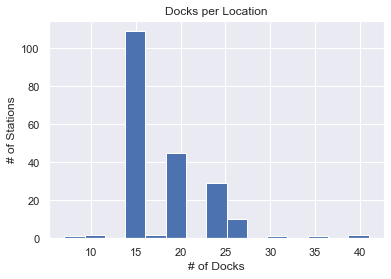

In [4]:
# Num Docks per Location
plt.figure()
plt.hist(station_location['Total docks'], 
         bins=15)
plt.ylabel('# of Stations')
plt.xlabel('# of Docks')
plt.title('Docks per Location')
plt.show()

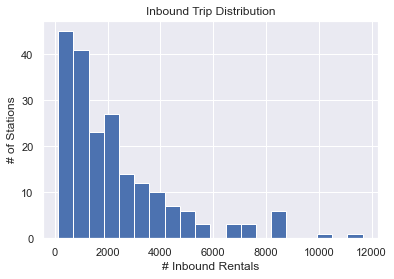

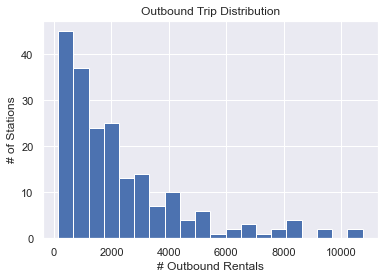

# Outbound Trips: 460718
# Inbound Trips: 460718


In [7]:
demand_df = pd.DataFrame({
    'Inbound trips': trip_history.groupby('End station').size(),
    'Outbound trips': trip_history.groupby('Start station').size()
})
demand_df['Name'] = demand_df.index
sdf = station_location.merge(demand_df, on='Name')

#inbound graph
plt.figure()
plt.hist(sdf['Inbound trips'], bins=20)
plt.ylabel('# of Stations')
plt.xlabel('# Inbound Rentals')
plt.title('Inbound Trip Distribution')
plt.show()

#outbound graph
plt.figure()
plt.hist(sdf['Outbound trips'], bins=20)
plt.ylabel('# of Stations')
plt.xlabel('# Outbound Rentals')
plt.title('Outbound Trip Distribution')
plt.show()

#confirm equal inbound vs outbound
print('# Outbound Trips: %d'%(sdf['Outbound trips'].sum()))
print('# Inbound Trips: %d'%(sdf['Inbound trips'].sum()))

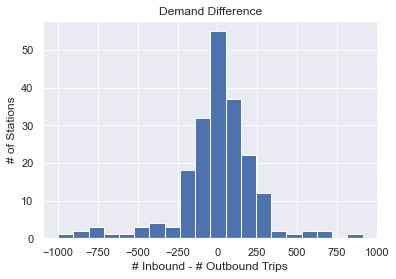

In [8]:
#inbound vs outbound trips
sdf['demand_diff'] = sdf['Inbound trips']-sdf['Outbound trips']

plt.figure()
plt.hist(sdf['demand_diff'], bins=20)
plt.ylabel('# of Stations')
plt.xlabel('# Inbound - # Outbound Trips')
plt.title('Demand Difference')
plt.show()

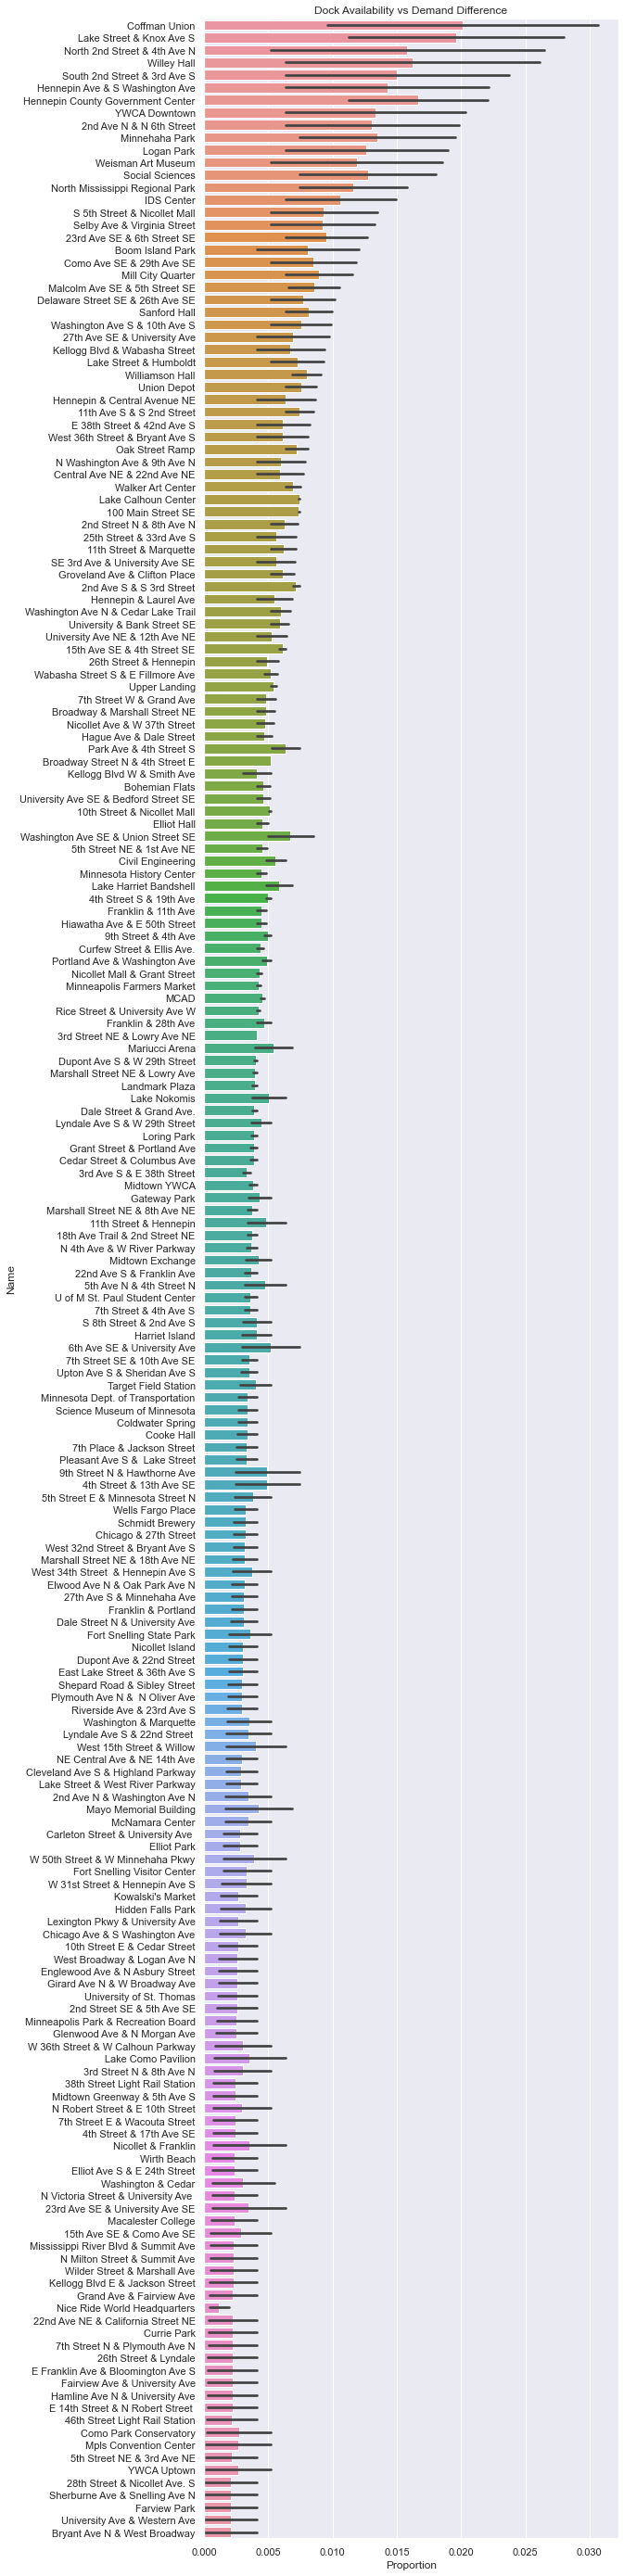

In [9]:
#find abslt value
sdf['abslt_diff'] = sdf['demand_diff'].abs()

#MAYBE DF = df[['id','pred', 'target']].replace(columns={'target':'y'})
#DF['diff'] = (oosDF['pred'] - oosDF['y']).abs()


#dock availability vs demand difference
sdf['Docks'] = sdf['Total docks']/sdf['Total docks'].sum()
sdf['DemandDiff'] = sdf['abslt_diff']/sdf['abslt_diff'].sum()

#?? make seaborn work!
seaborn_data_cleaned = (
    sdf[['Name', 'Docks', 'DemandDiff']]
       .set_index('Name')
       .stack()
       .reset_index()
       .rename(columns={'level_1':'Distribution', 0:'Proportion'})
)

#graph
plt.figure(figsize=(8, 50))
station_list = (
    sdf
    .sort_values('DemandDiff', ascending=False)['Name']
    .tolist()
)

sns.barplot(y='Name', x='Proportion',data=seaborn_data_cleaned, order=station_list)

plt.title('Dock Availability vs Demand Difference')
sns.color_palette("rocket", as_cmap=True)
plt.show()


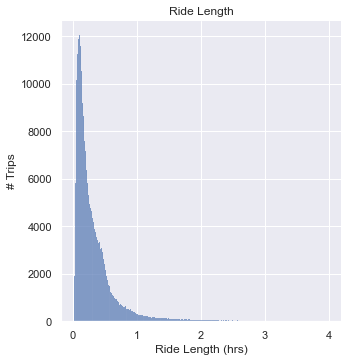

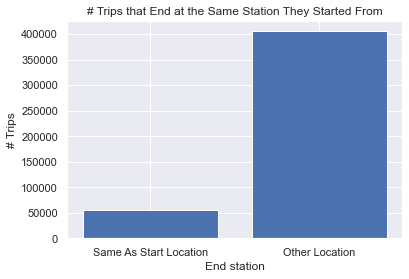

In [10]:
trips = (
    trip_history.groupby(['Start station', 'End station'])['Start Date']
    .count().to_frame().reset_index()
    .rename(columns={"Start Date": "Trips"})
    .pivot(index='Start station', columns='End station')
    .fillna(value=0)
)

#Ride Length
sns.displot(trip_history.loc[trip_history['Total duration (Seconds)']<(4*60*60),
                       'Total duration (Seconds)']/3600)
plt.xlabel('Ride Length (hrs)')
plt.ylabel('# Trips')
plt.title('Ride Length')
plt.show()

#Return Location

plt.bar([0, 1], 
        [np.trace(trips.values), 
         trips.values.sum()-np.trace(trips.values)],
        tick_label=['Same As Start Location', 'Other Location'])
plt.xlabel('End station')
plt.ylabel('# Trips')
plt.title('# Trips that End at the Same Station They Started From')
plt.show()


C:\Users\mango\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


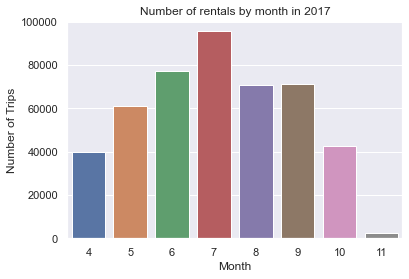

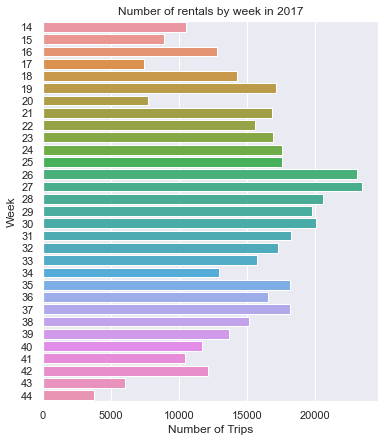

C:\Users\mango\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


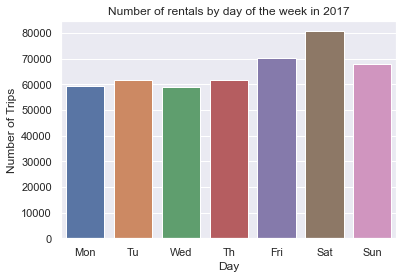

In [11]:
#change date from object to date datatype
for col in ['Start Date', 'End Date']:
    trip_history[col] = pd.to_datetime(trip_history[col],
                                format='%m/%d/%Y')
    
# num rentals per month    
plt.figure()
sns.countplot(trip_history['Start Date'].dt.month)
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.title('Number of rentals by month in 2017')
plt.show()

# num rentals per week 
plt.figure(figsize=(6, 7))
sns.countplot(y=trip_history['Start Date'].dt.isocalendar().week)
plt.ylabel('Week')
plt.xlabel('Number of Trips')
plt.title('Number of rentals by week in 2017')
plt.show()

#num rentals per day of the week
plt.figure()
sns.countplot(trip_history['Start Date'].dt.weekday)
plt.xlabel('Day')
plt.ylabel('Number of Trips')
plt.title('Number of rentals by day of the week in 2017')
plt.xticks(np.arange(7),
           ['Mon', 'Tu', 'Wed', 'Th', 'Fri', 'Sat', 'Sun'])
plt.show()

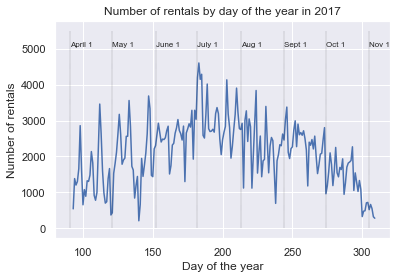

In [12]:
gt = trip_history.groupby(trip_history['Start Date'].dt.dayofyear)['Start Date']
gt.count().plot()
plt.xlabel('Day of the year')
plt.ylabel('Number of rentals')
plt.title('Number of rentals by day of the year in 2017')

month_first = [("April 1", 91),
            ("May 1", 121),
            ("June 1", 152),
            ("July 1", 182),
            ("Aug 1", 213),
            ("Sept 1", 244),
            ("Oct 1", 274),
            ("Nov 1", 305)]
for name, day in month_first:
    plt.plot([day,day], [0,5500], 
             'k--', linewidth=0.2)
    plt.text(day, 5200, name, fontsize=8, 
             va='top')

plt.show()


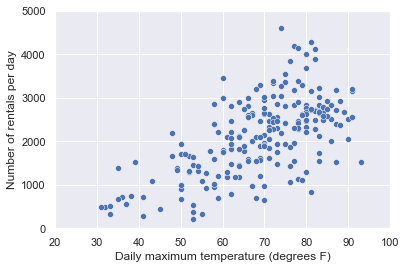

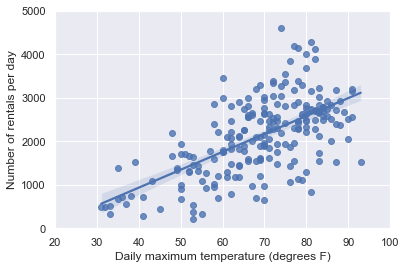

In [13]:
weather = pd.read_csv('WeatherDailyMinneapolis2017.csv', low_memory=False)
for col in ['DATE']:
    weather[col] = pd.to_datetime(weather[col],
                                format='%m/%d/%y')


trips_per_day = (
    trip_history
    .groupby(trip_history['Start Date'].dt.dayofyear)
    .size()
    .rename('trips')
)

# Add the trips to weather table
weather['dayofyear'] = weather.DATE.dt.dayofyear
weather = (
    weather
    .set_index('dayofyear')
    .join(trips_per_day)
)

#max temp vs #trips per day
sns.scatterplot(x='TMAX', y='trips', data=weather)
plt.xlabel('Daily maximum temperature (degrees F)')
plt.ylabel('Number of rentals per day')
plt.xlim([20, 100])
plt.ylim([0, 5000])
plt.show()

#graph with regression
sns.regplot(x='TMAX', y='trips', data=weather)
plt.xlabel('Daily maximum temperature (degrees F)')
plt.ylabel('Number of rentals per day')
plt.xlim([20, 100])
plt.ylim([0, 5000])
plt.show()


In [14]:
!jupyter nbconvert  saif.ipynb --to html

[NbConvertApp] Converting notebook saif.ipynb to html
[NbConvertApp] Writing 1500528 bytes to saif.html
